For this step we're going to use Keras. This will also start up your GPU if you're using one, which can take up to **10 seconds**.

In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten, Reshape
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils

Using TensorFlow backend.


Now let's load the data, and convert the labels to categories. So `0` becomes `[1, 0]` and `1` becomes `[0, 1]`. This makes it easy to add more classes later (like "angry", "sad", etc.) and interpret the predictions as probabilities. We do this after loading the file instead of before saving to avoid having a big labels file on disk.

Then we shuffle all the examples to make sure we don't hold out only one class for validation. And finally we count up how many instances there are of each class to make ensure that we put more emphasis on the rarer ones during training.

In [2]:
# load the data
X = np.load('X.npy')
y = np.load('y.npy')

# convert classes to vector
nb_classes = 2
y = np_utils.to_categorical(y, nb_classes).astype(np.float32)

# shuffle all the data
indices = np.arange(len(X))
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

# prepare weighting for classes since they're unbalanced
class_totals = y.sum(axis=0)
class_weight = class_totals.max() / class_totals

print X.dtype, X.min(), X.max(), X.shape
print y.dtype, y.min(), y.max(), y.shape

float32 0.0 1.0 (13165, 32, 32, 1)
float32 0.0 1.0 (13165, 2)


Now we set up our network. It is based on the Keras `mnist_cnn.py` example, following in the footsteps of VGG net by using small 3x3 convolutions with max pooling, and a final stage of multiple dense layers.

In [3]:
nb_filters = 32
nb_pool = 2
nb_conv = 3

model = Sequential()

model.add(Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu', input_shape=X.shape[1:]))
model.add(Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               802944    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

Now that our data and model is ready, we can train the model on the data for a few epochs, holding out 10% of the data for validating the accuracy. This should take about **30 seconds**.

In [4]:
validation_split = 0.10
model.fit(X, y, batch_size=128, class_weight=class_weight, epochs=5, verbose=1, validation_split=validation_split)

Train on 11848 samples, validate on 1317 samples
Epoch 1/5
11848/11848 [==============================] - 18s - loss: 0.4642 - acc: 0.7770 - val_loss: 0.3019 - val_acc: 0.8815

That got us to 90% validation accuracy, following the training accuracy pretty closely. To get it down more we might try tweaking the hyperparameters (number of filters, size of dense layers, etc.) or lowering the learning rate after a few epochs. But for now we will just save the model.

In [5]:
open('model.json', 'w').write(model.to_json())
model.save_weights('weights.h5')

To visually check the accuracy and loss, we can plot them to verify that there aren't any unexpected kinks or noise.

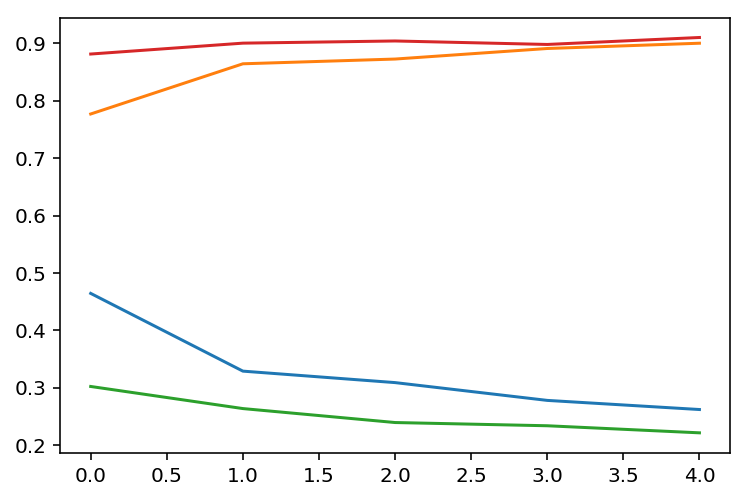

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(model.model.history.history['loss'])
plt.plot(model.model.history.history['acc'])
plt.plot(model.model.history.history['val_loss'])
plt.plot(model.model.history.history['val_acc'])
plt.show()

Bonus (optional): let's check the area under the receiver operating characteristic curve (ROC AUC) so we can compare to other work.

In [7]:
from sklearn.metrics import roc_auc_score
n_validation = int(len(X) * validation_split)
y_predicted = model.predict(X[-n_validation:])
print roc_auc_score(y[-n_validation:], y_predicted)

0.963608965356
